<h2>Initialize all imports</h2>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import time

2025-08-07 14:43:00.143205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-07 14:43:00.403987: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

## Read Input data & Change directory

In [2]:
# Depickle the PDB(Protein Data Bank) and read csv with data
PDBs = pickle.load(open('Datasets/PDBs_RDKit_BFE.pkl', 'rb'))
df = pd.read_csv('Datasets/Final_data_DDG.csv')


In [3]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)
from models.PGCN_model_multiloss import get_trained_model, test_model

## Data pre-processing

In [4]:
# Iterate through each pdb. Look at current pdb position (row) and extract the information and store as a numpy array
# Note: Host is the receptor component which provides the binding site
# - Guest is the molecule that binds to the host
# - Complex is the bound state between guest and host and typically binding energy
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])

In [5]:
# Function takes in a molecule and information

def featurize(molecule, info):
    atom_features = []
    # Iterate through each atom
    for atom in molecule.GetAtoms():
        # List of features for the atom
        new_feature = get_atom_features(atom).tolist() 
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        # Store mass, atomic number, formal charge
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        # Store 3D position
        new_feature += [position.x, position.y, position.z]
        # Track neighboring atoms
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
# X is the featurized molecule and y is the experimental binding free energy
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])


[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValen

[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:43:15] DEPRECATION WARNING: please use GetValen

In [7]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)


(57, 15, 57, 15)

## Helper Functions

<h3 style="color:red;">PCGrad Class</h3>

In [9]:
print(tf.__version__)

2.11.1


In [10]:
import tensorflow as tf
import numpy as np

class PCGrad(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, name="PCGrad", **kwargs):
        # MUST be called first!
        super().__init__(name=name, **kwargs)
        self._optimizer = optimizer
    @property
    def learning_rate(self):
        return self._optimizer.learning_rate

    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        return self._optimizer.apply_gradients(grads_and_vars, name, **kwargs)

    def _create_slots(self, var_list):
        self._optimizer._create_slots(var_list)

    def _prepare(self, var_list):
        self._optimizer._prepare(var_list)

    def get_config(self):
        config = super().get_config()
        config.update({"optimizer": tf.keras.optimizers.serialize(self._optimizer)})
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer_config = config.pop("optimizer")
        optimizer = tf.keras.optimizers.deserialize(optimizer_config, custom_objects=custom_objects)
        return cls(optimizer, **config)

    def compute_gradients(self, losses, tape, var_list):
        """Compute PCGrad projected gradients from a list of task losses."""
        assert isinstance(losses, list), "loss must be a list of task losses"
        grads_task = []

        for loss in losses:
            grads = tape.gradient(loss, var_list)
            grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, var_list)]
            grads_task.append(grads)

        # Flatten and apply projection
        def flatten(grads):
            return tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

        flat_grads_task = [flatten(g) for g in grads_task]
        flat_grads_task = tf.stack(flat_grads_task)
        #flat_grads_task = tf.random.shuffle(flat_grads_task)

        def project(g, others):
            for o in others:
                dot = tf.reduce_sum(g * o)
                if dot < 0:
                    g -= dot / (tf.reduce_sum(o * o) + 1e-12) * o
            return g

        projected = []
        for i in range(len(flat_grads_task)):
            others = tf.concat([flat_grads_task[:i], flat_grads_task[i+1:]], axis=0)
            projected.append(project(flat_grads_task[i], others))
        projected = tf.stack(projected)

        # Average the projected gradients and reshape
        mean_grad = tf.reduce_mean(projected, axis=0)

        reshaped_grads = []
        idx = 0
        for v in var_list:
            shape = tf.shape(v)
            size = tf.reduce_prod(shape)
            reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
            idx += size

        return list(zip(reshaped_grads, var_list))

In [11]:
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=1e-3))

2025-08-07 14:43:18.216185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-07 14:43:18.216220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-08-07 14:43:18.220073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class PGGCN_Hybrid(tf.keras.Model):
    # num_atom_features - number of features per atom
    # r_out_channel - number of output channels for graph convolutional layer (size of each output sample)
    # c_out_channel - number of output channels convolutional layer (size of each output sample)
    # l2 - regularization coefficient
    # drouput_rate - dropout rate for regularization (helps reduce overfitting)
    # maxnorm - norm constraint for the weight vectors
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        # Initialize RuleGraphConvLayer and set the out_channel to be 20 and number of features to be 36
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        # Initialize empty list of combination rules
        self.ruleGraphConvLayer.combination_rules = []
        # Initialize the Convolutional layer. Set the out_channel to be 128 and number of features as the other out_channel (20)
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        # Set the dense layer to 32 units, relu activation, use kernel regularizer l2 and use it as a bias regularizer, and add maxnorm constraint
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # Set the dropout rate
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        # Set dense layer to 16 units and same activation, regularizer, and maxnorm constraint
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # The weights have been manually set to a specific pattern based on the physics coefficients
        # Bias innitializers are set to 0 so there is no offset (rely on weights and features)
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))

    # adds rule to RuleGraphConvLayer (see layers_update_mobley.py)
    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    # It's internal and it's called everytime you call the class and sets the physics info and it's run through the labels 
    def call(self, inputs, training=True):
        print("Inside call")
        physics_info = inputs[:, 0, 38:]
        #x_a = [inputs[i, :, :38] for i in range(tf.shape(inputs)[0])]

        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)

# Callback function which displays empirical loss, physical loss, totall loss and learning rates for each epoch
class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model_instance = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model_instance.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model_instance.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def pure_rmse_hybrid(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dG_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [0, 3, 6, 9, 12], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [1, 4, 7, 10, 13], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [2, 5, 8, 11, 14], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    

    return phy_loss


# Output of the empirical loss is going to be a tensor and we have to convert it into a number value
def combined_loss(physics_hyperparam=0.0003):
    
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:16]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse_hybrid(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Append losses to a list and return
        losses = []
        losses.append(empirical_loss)
        losses.append(physics_loss)
        
        # Keep track each of the loss values. Total loss is returned
        # The value ones are logs for the history
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 

        return total_loss
    
    return loss_function

In [13]:
physics_hyperparam = [0.005]
epochs = [250]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    

---------- Hyperparameter combinations ------------
Epoch: 250;  physics_weight: 0.005
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/250 - Total: 9.0853, Empirical: 8.9546, Physics: 26.1366
Inside call
Epoch 2/250 - Total: 16.4521, Empirical: 16.3432, Physics: 21.7701
Inside call
Epoch 3/250 - Total: 7.8213, Empirical: 7.7302, Physics: 18.2288
Inside call
Epoch 4/250 - Total: 10.8790, Empirical: 10.7589, Physics: 24.0244
Inside call
Epoch 5/250 - Total: 12.2806, Empirical: 12.1508, Physics: 25.9635
Inside call
Epoch 6/250 - Total: 8.0976, Empirical: 7.9795, Physics: 23.6180
Inside call
Epoch 7/250 - Total: 4.0218, Empirical: 3.9218, Physics: 19.9974
Inside call
Epoch 8/250 - Total: 7.6867, Empirical: 7.5947, Physics: 18.4016
Inside call
Epoch 9/250 - Total: 7.9083, Empirical: 7.8200, Physics: 17.6427
Inside call
E

Epoch 65/250 - Total: 2.6219, Empirical: 2.5299, Physics: 18.4000
Inside call
Epoch 66/250 - Total: 2.6137, Empirical: 2.5219, Physics: 18.3644
Inside call
Epoch 67/250 - Total: 2.6118, Empirical: 2.5193, Physics: 18.5026
Inside call
Epoch 68/250 - Total: 2.6086, Empirical: 2.5154, Physics: 18.6270
Inside call
Epoch 69/250 - Total: 2.5972, Empirical: 2.5047, Physics: 18.5090
Inside call
Epoch 70/250 - Total: 2.5985, Empirical: 2.5069, Physics: 18.3263
Inside call
Epoch 71/250 - Total: 2.5871, Empirical: 2.4952, Physics: 18.3876
Inside call
Epoch 72/250 - Total: 2.5859, Empirical: 2.4930, Physics: 18.5829
Inside call
Epoch 73/250 - Total: 2.5806, Empirical: 2.4877, Physics: 18.5717
Inside call
Epoch 74/250 - Total: 2.5726, Empirical: 2.4806, Physics: 18.3853
Inside call
Epoch 75/250 - Total: 2.5691, Empirical: 2.4774, Physics: 18.3348
Inside call
Epoch 76/250 - Total: 2.5647, Empirical: 2.4725, Physics: 18.4484
Inside call
Epoch 77/250 - Total: 2.5580, Empirical: 2.4655, Physics: 18.490

Epoch 170/250 - Total: 2.2251, Empirical: 2.1330, Physics: 18.4073
Inside call
Epoch 171/250 - Total: 2.2224, Empirical: 2.1304, Physics: 18.4056
Inside call
Epoch 172/250 - Total: 2.2198, Empirical: 2.1278, Physics: 18.4052
Inside call
Epoch 173/250 - Total: 2.2172, Empirical: 2.1252, Physics: 18.4064
Inside call
Epoch 174/250 - Total: 2.2146, Empirical: 2.1226, Physics: 18.4042
Inside call
Epoch 175/250 - Total: 2.2121, Empirical: 2.1200, Physics: 18.4048
Inside call
Epoch 176/250 - Total: 2.2095, Empirical: 2.1175, Physics: 18.4036
Inside call
Epoch 177/250 - Total: 2.2069, Empirical: 2.1149, Physics: 18.4042
Inside call
Epoch 178/250 - Total: 2.2044, Empirical: 2.1124, Physics: 18.4026
Inside call
Epoch 179/250 - Total: 2.2019, Empirical: 2.1099, Physics: 18.4024
Inside call
Epoch 180/250 - Total: 2.1994, Empirical: 2.1074, Physics: 18.4028
Inside call
Epoch 181/250 - Total: 2.1969, Empirical: 2.1049, Physics: 18.4015
Inside call
Epoch 182/250 - Total: 2.1945, Empirical: 2.1025, Ph

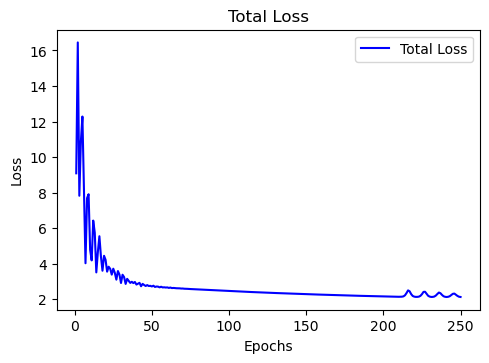

In [14]:
for epoch in epochs:
    for physics_weight in physics_hyperparam:
        print("---------- Hyperparameter combinations ------------")
        print(f"Epoch: {epoch};  physics_weight: {physics_weight}")
        
        start_time = time.time()
        
        m = PGGCN_Hybrid()
        m.addRule("sum", 0, 32)
        m.addRule("multiply", 32, 33)
        m.addRule("distance", 33, 36)

        opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

        input_shapes = [X.shape[0] for X in X_train]
        m.set_input_shapes(input_shapes)
        for i in range(len(X_train)):
            if X_train[i].shape[0] < 2000:
                X_train[i] = np.concatenate([X_train[i], np.zeros([2000 - X_train[i].shape[0], 53])], axis=0)
                
        # Error: InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Sub]
        # Convert both to the same type
        X_train = np.array(X_train).astype(np.float32)
        y_train = np.array(y_train).astype(np.float32)

        total_losses = []
        empirical_losses = []
        physics_losses = []
        
        loss_tracker = LossComponentsCallback_Hybrid(m)

        for ep in range(epoch):
            with tf.GradientTape(persistent=True) as tape:
                predictions = m(X_train, training=True)
        
                # Empirical loss and physics loss calculated in loss_function
                emp_loss = pure_rmse_hybrid(y_train, predictions[:, 0])
                phy_loss = physical_consistency_loss(y_train, predictions[:, 0], predictions[:, 1:16])
                total_loss = emp_loss + physics_weight * phy_loss

            grads_and_vars = opt.compute_gradients([emp_loss, physics_weight * phy_loss], tape, m.trainable_variables)
            opt.apply_gradients(grads_and_vars)

            # Logging
            total_losses.append(float(total_loss.numpy()))
            empirical_losses.append(float(emp_loss.numpy()))
            physics_losses.append(float(phy_loss.numpy()))

            print(f"Epoch {ep+1}/{epoch} - Total: {total_loss.numpy():.4f}, Empirical: {emp_loss.numpy():.4f}, Physics: {phy_loss.numpy():.4f}")

        # Evaluation phase
        for i in range(len(X_test)):
            if X_test[i].shape[0] < 2000:
                X_test[i] = np.concatenate([X_test[i], np.zeros([2000 - X_test[i].shape[0], 53])], axis=0)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # m.predict is causing errors. Instead
        #y_pred_test = m.predict(X_test)
        #y_pred_test = y_pred_test[:, 0]
        y_pred_test = []
        for i in range(len(X_test)):
            m.set_input_shapes([input_shapes[i]])
            pred = m(X_test[i][np.newaxis, ...], training=False)
            y_pred_test.append(pred[0, 0].numpy())
        y_pred_test = np.array(y_pred_test)
        y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
        # Was giving an error so I had to change it to a manual calculation
        #eval = m.evaluate(X_test, y_test)
        test_emp_loss = pure_rmse_hybrid(y_test, y_pred_test)
        test_phy_loss = physical_consistency_loss(y_test, y_pred_test, X_test[:, 0, 38:53])
        test_loss = test_emp_loss + physics_weight * test_phy_loss

        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Total time: {elapsed:.2f} seconds")
        print("The mean absolute difference between y_true & y_pred is:", y_difference)

        result_temp = {
            'name': 'ΔΔG with Multi-Loss',
            'y_test': y_test,
            'test_loss': float(test_loss.numpy()),
            'y_pred_test': y_pred_test,
            'MAD': y_difference,
            'all_losses': total_losses,
            'empirical_losses': empirical_losses,
            'physical_losses': physics_losses,
            'hyperparameters': {
                'physics_weight': physics_weight,
                'epochs': epoch,
                'initial_learning_rate': 0.005,
                'decay_steps': 10000,
                'decay_rate': 0.9
            }
        }

        results["multi_loss_run"] = result_temp
        all_results.append(result_temp)

        # Plotting
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(range(1, len(total_losses) + 1), total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

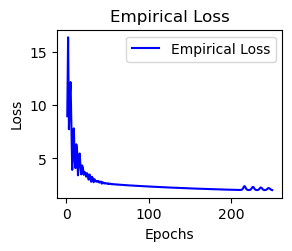

In [15]:
epoch_length = range(1, len(empirical_losses) + 1)
plt.subplot(2, 2, 1)
plt.plot(epoch_length, empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

In [17]:
print(hybrid_y_true)
print(hybrid_y_pred)

[3.597 4.97  2.13  2.022 3.394 4.52  1.506 1.458 2.51  5.04  3.72  1.554
 1.575 4.73  3.344]
[ 6.4199657   7.640371    2.8721743   1.7588848   3.7634072   9.113013
  0.382128    3.0071833   4.8475623   4.8392625   5.4651055  -1.078389
 -0.68632305  5.331737    0.22509944]


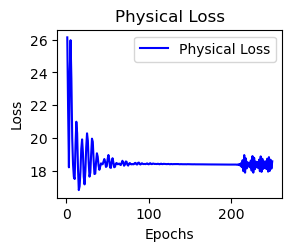

In [18]:
epoch_length = range(1, len(physics_losses) + 1)
plt.subplot(2, 2, 1)
plt.plot(epoch_length, physics_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

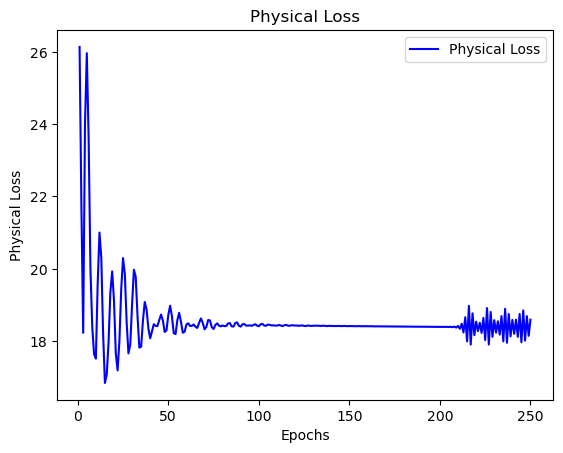

In [19]:


# hist is the History object returned by .fit()
plt.plot(epoch_length, physics_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')

plt.xlabel('Epochs')
plt.ylabel('Physical Loss')
plt.legend()
plt.show()

In [20]:
print(len(empirical_losses))
print(len(physics_losses))

250
250


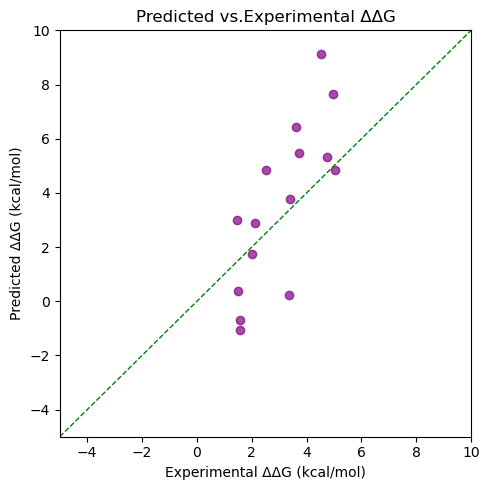

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Predicted vs.Experimental ΔΔG")
plt.scatter(y_test, y_pred_test, alpha=0.7, color="purple")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Predicted_vs_Experimental_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITHOUT LOSS

In [22]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [23]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValen

[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:52:41] DEPRECATION WARNING: please use GetValen

In [24]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        #self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        final_weights = mn.ruleGraphConvLayer.w_s  # capture after training

        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)


# PCGrad optimizer
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
mn.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_nohyb = np.array(X_train).astype(np.float32)
y_train_nohyb = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_nohyb = []
epochs = 400

for ep in range(epochs):
    epoch_start = time.time()

    with tf.GradientTape() as tape:
        preds = mn(X_train_nohyb, training=True)
        loss = pure_rmse(y_train_nohyb, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, mn.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_nohyb.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    # Displaying Each epoch one by one seems to take up a lot of time
    # Each epoch takes 90s to run, there are 400 so it would finish in 10 hours
    # Unfortunately it also kills the kernel so running at every 10 for now
    if ep % 10 == 0 or ep == epochs - 1:
        print(f"Epoch {ep+1}/{epochs}")
        print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")


# Plot
plt.plot(range(1, epochs + 1), loss_tracker_nohyb, label="Empirical Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE NoHybrid - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/400
1/1 [==============================] - 21s 21s/step - loss: 9.8987
Epoch 11/400
1/1 [==============================] - 1s 1s/step - loss: 5.7134
Epoch 21/400
1/1 [==============================] - 1s 1s/step - loss: 6.4751
Epoch 31/400
1/1 [==============================] - 1s 1s/step - loss: 5.5923
Epoch 41/400
1/1 [==============================] - 1s 1s/step - loss: 5.1319
Epoch 51/400
1/1 [==============================] - 1s 1s/step - loss: 4.9478
Epoch 61/400
1/1 [==============================] - 1s 1s/step - loss: 4.9060
Epoch 71/400
1/1 [==============================] - 1s 1s/step - loss: 4.8591
Epoch 81/400
1/1 [==============================] - 1s 1s/step - loss: 4.8320
Epoch 91/400
1/1 [==============================] - 1s 1s/step - loss: 4.8087
Epoch 101/400
1/1 [==============================] - 1s 1s/step - loss: 4.7862
Epoch 111/400
1/1 [==============================] - 1s 1s/step - loss: 4.7638
Epoch 121/400
1/1 [==============================] - 1s 1s/st

In [ ]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = pure_rmse(y_test_nohyb, y_pred_test_nohyb).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))


result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_nohyb, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Pure RMSE Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('DDG_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITH STRUCTURAL

In [ ]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [ ]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
    
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms = PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)

opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
ms.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_struct = np.array(X_train).astype(np.float32)
y_train_struct = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_struct = []

# Manual training loop
epochs = 250
for ep in range(epochs):
    epoch_start = time.time()
    with tf.GradientTape() as tape:
        preds = ms(X_train_struct, training=True)
        loss = pure_rmse(y_train_struct, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, ms.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_struct.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    print(f"Epoch {ep+1}/{epochs}")
    print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")

plt.plot(range(1, epochs + 1), loss_tracker_struct, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE Structural - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_struct, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [ ]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 53])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
#eval_struct = ms.evaluate(X_test_struct, y_test_struct)
eval_struct = pure_rmse(y_test_struct, y_pred_test_struct).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line

plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔΔG Comparison between Traditional Loss, Empirical, Physical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Save individual run results
individual_filename = f'/home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")